In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import time
#A continuación se importan laas librerias necesarias para el entrenamiento de la red 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import ConvLSTM2D
from keras.layers import Flatten


Using TensorFlow backend.


(210870,)


Text(0.5, 1.0, 'Datos reales')

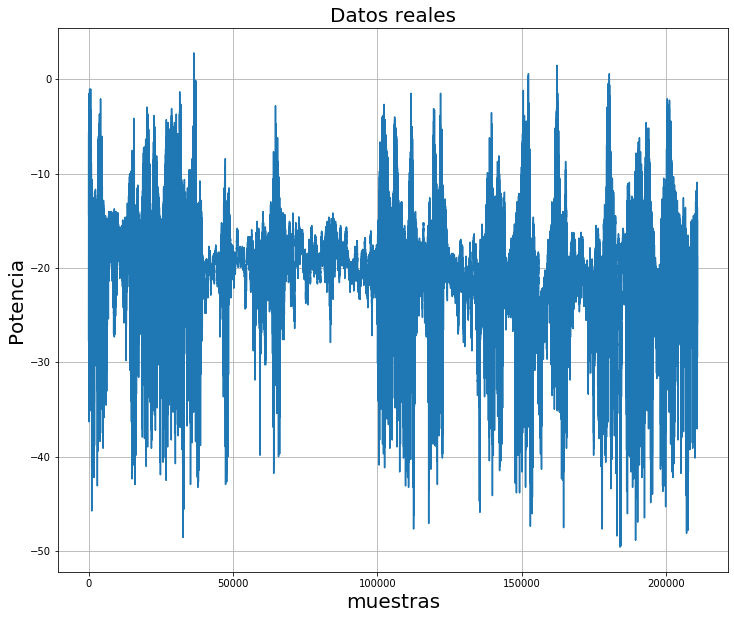

In [12]:
dataframe = pd.read_csv('/content/drive/My Drive/LSTM /Mediciones en csv/LTNLOS CSV/potencia 2000-01-30 20_3A40_3A27 Antenna Horn Time 300[s] SwitchingBy 0 Horn 0 Omni 0 FIN_009.csv', header=None )
#llevar al dataframe a un arreglo de valores
dataset = dataframe.values
#dataset solo para la funcion senoidal
POT = dataset[0:len(dataset),1]
#POT = dataset
print(POT.shape)
plt.figure(figsize=[12,10])
plt.grid()
plt.plot(POT)
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.title("Datos reales", fontsize = 20)

# Nueva sección

In [13]:
#llevo la funcion a un arreglo de [lARGO DEL ARREGLO ,1] PARA ESCALAR LOS DATOS y que la red aprenda de mejor forma
POT2=POT.reshape(len(POT),1)
print(POT2.shape)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
POT2 = scaler.fit_transform(POT2)

(210870, 1)


In [14]:
# divido la funcion y1 en arreglos para entrenar y probar la red
train_size = int(len(POT2) * 0.8)
test_size = len(POT2) - train_size
train, test = POT2[0:train_size,:], POT2[train_size:len(POT2),:]
print(len(train), len(test))
print(train.shape)
print(test.shape)

168696 42174
(168696, 1)
(42174, 1)


In [0]:
# convertir un arreglo de valores en una matrix
def create_dataset(POT2, look_back=1):
    dataX, dataY = [], []
    for i in range(len(POT2)-look_back-1):
        a = POT2[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(POT2[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
# reshape dentro X=t and Y=t+1
look_back = 128
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)
#print(trainX[0])
#print(trainY[0])
#print(trainX[1])
#print(trainY[1])
#print(trainX[2])
#print(trainY[3])

(168567, 128)
(42045, 128)
(168567,)
(42045,)


In [0]:
#n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length, n_features = 4, 32, 1
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 4, 1, 29, 128)     264704    
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 1, 29, 128)     0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 1, 26, 128)        524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 26, 128)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3328)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               426112    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)              

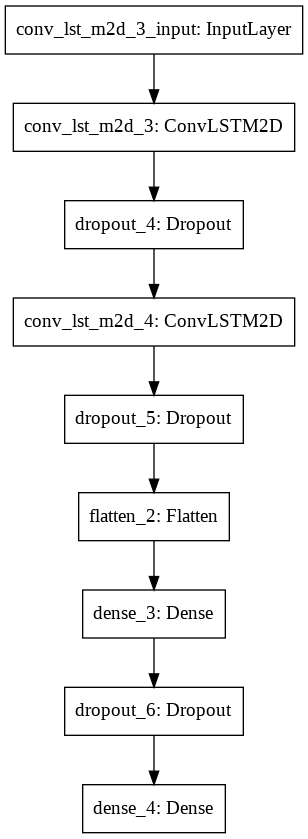

In [18]:
model = Sequential()
model.add(ConvLSTM2D(filters=128, kernel_size=(1,4), return_sequences = True ,activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
#model.add(ConvLSTM2D(filters=32, kernel_size=(1,3), input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.3))
model.add(ConvLSTM2D(filters=128, kernel_size=(1,4), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
#model.add(LSTM(input_shape = (None, None, 32, 1), output_dim= 128, return_sequences = True))
model.add(Dropout(0.3))
#model.add(LSTM(128))
#model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(1))

# define model
#model = Sequential()
#model.add(ConvLSTM2D(filters=128, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
#model.add(Dropout(0.3))
#model.add(Flatten())
#model.add(Dense(100, activation='relu'))
#model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.summary()
keras.utils.plot_model(model, 'my_first_model.png')

In [0]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
filepath="Checkpoint_mejores_pesos.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_absolute_percentage_error', verbose=1, save_best_only=True, mode='min')
# simple early stopping
es = EarlyStopping(monitor='val_mean_absolute_percentage_error', mode='min', verbose=1, patience=5)

In [20]:
batch_size= 32 
epochs= 10
start = time.time()
History_htnlos1 = model.fit(trainX, trainY,batch_size=batch_size, epochs= epochs, callbacks=[es, checkpoint] , validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

Train on 151710 samples, validate on 16857 samples
Epoch 1/10
151710/151710 [==============================] - 164s 1ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0454 - mean_absolute_percentage_error: 8.4386 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0383 - val_mean_absolute_percentage_error: 8.7603

Epoch 00001: val_mean_absolute_percentage_error improved from inf to 8.76032, saving model to Checkpoint_mejores_pesos.hdf5
Epoch 2/10
151710/151710 [==============================] - 161s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 6.5977 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0313 - val_mean_absolute_percentage_error: 7.0234

Epoch 00002: val_mean_absolute_percentage_error improved from 8.76032 to 7.02338, saving model to Checkpoint_mejores_pesos.hdf5
Epoch 3/10
151710/151710 [=============================

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model_ltnlos_señal1.json", "w") as json_file:
    json_file.write(model_json)


In [0]:
import pickle

pickle_out = open("History_htnlos1.pickle","wb")
pickle.dump(History_htnlos1, pickle_out)
pickle_out.close()

In [0]:
import pickle 

pickle_in = open("History_htnlos1.pickle","rb")
History_saved = pickle.load(pickle_in)


In [0]:
History = History_saved

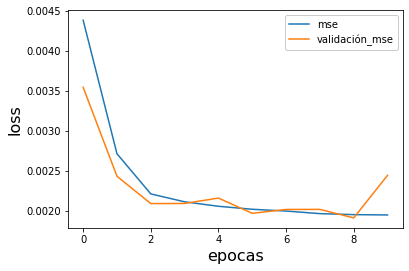

In [25]:
# plot metrics
#plt.figure(figsize=[8,8])
plt.plot(History.history['mean_squared_error'], label='mse')
plt.plot(History.history['val_mean_squared_error'], label= 'validación_mse')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

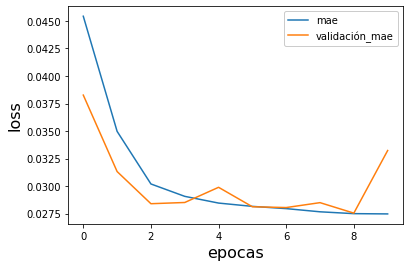

In [26]:
plt.plot(History.history['mean_absolute_error'], label='mae')
plt.plot(History.history['val_mean_absolute_error'], label= 'validación_mae')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

In [0]:
#History.history['mean_absolute_percentage_error']

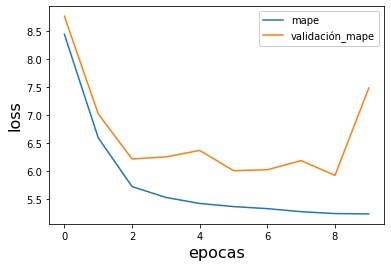

In [28]:
plt.plot(History.history['mean_absolute_percentage_error'], label= 'mape')
plt.plot(History.history['val_mean_absolute_percentage_error'], label= 'validación_mape')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

In [29]:
# predicciones de los valores de prueba
prediccion_test = model.predict(testX)
prediccion_test = scaler.inverse_transform(prediccion_test)
#actuals = test_y
valor_real_test = scaler.inverse_transform([testY])
valor_real_test= valor_real_test.reshape(len(prediccion_test),1)
#prediccion de los valores de entrenamiento
aprendido=model.predict(trainX)
aprendido_train=scaler.inverse_transform(aprendido)
reales_train=scaler.inverse_transform([trainY])
reales_train=scaler.inverse_transform([trainY])
reales_train=reales_train.reshape(len(aprendido),1)
###################################################
mse_aprendido=mean_squared_error(reales_train,aprendido_train)
mse_test=mean_squared_error(valor_real_test,prediccion_test)
print('Train Mean square Error:', mse_aprendido)
print('Test Mean square Error:', mse_test)
#######################################################
rmse_train=math.sqrt(mse_aprendido)
rmse_test=math.sqrt(mse_test)
print('Train Root Mean Squared Error:', rmse_train)
print('Test Root Mean Squared Error:', rmse_test)


Train Mean square Error: 5.178140604866076
Test Mean square Error: 7.988324789815459
Train Root Mean Squared Error: 2.2755528130250187
Test Root Mean Squared Error: 2.826362466106472


In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
#mape train
mean_absolute_percentage_error(reales_train,aprendido_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


inf

In [32]:
#mape test
mean_absolute_percentage_error(valor_real_test,prediccion_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


inf

In [0]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

In [34]:
smape(reales_train,aprendido_train)

7.552851734724843

In [35]:
smape(valor_real_test,prediccion_test)

9.215270121623659

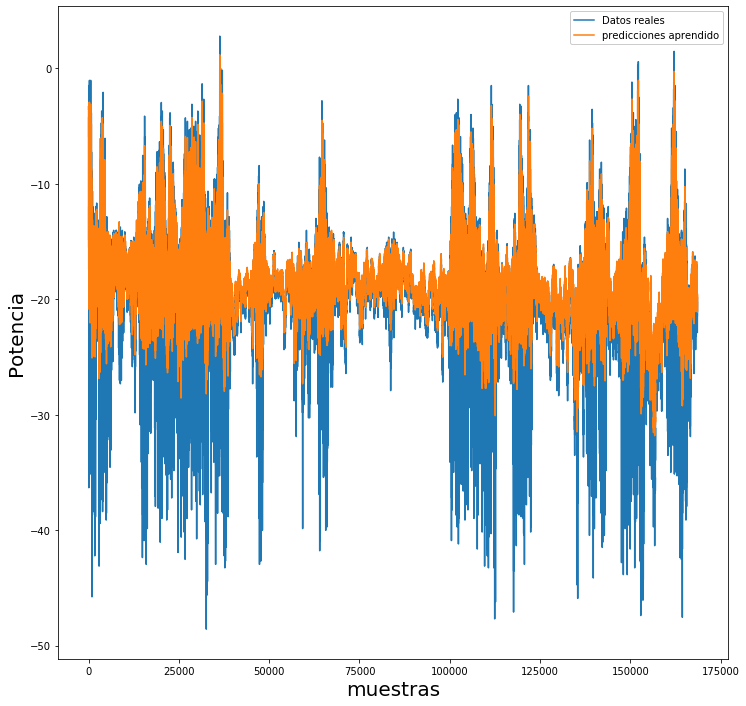

In [36]:
# plot entrenamiento
plt.figure(figsize=[12,12])
plt.plot(reales_train, label='Datos reales')
plt.plot(aprendido_train, label= 'predicciones aprendido')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

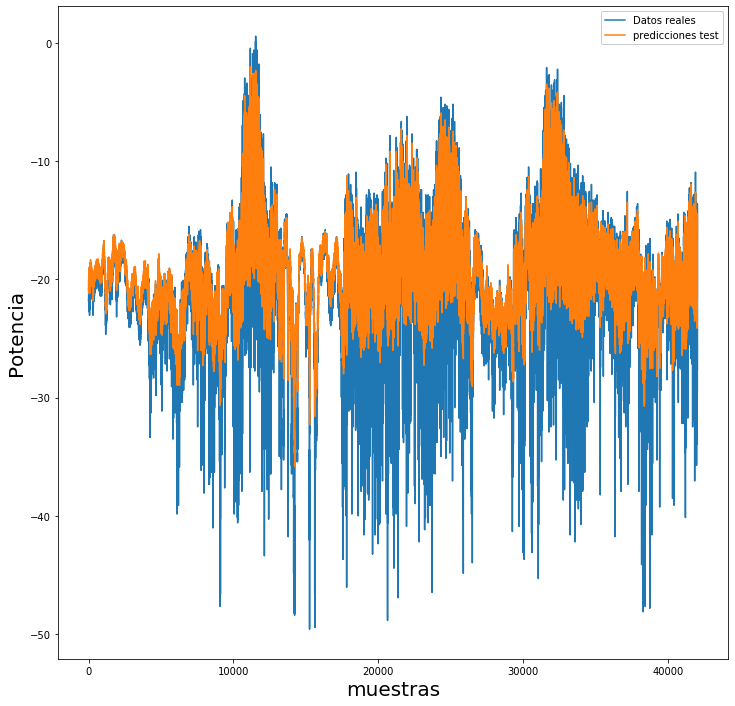

In [37]:
# plot test
plt.figure(figsize=[12,12])
plt.plot(valor_real_test, label='Datos reales')
plt.plot(prediccion_test , label= 'predicciones test')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

In [38]:
acc = abs(prediccion_test-valor_real_test)
porc_error = (acc / abs(valor_real_test)) * 100
mostrar = valor_real_test, prediccion_test, acc, porc_error
Tabla_arr = np.array(mostrar)
Tabla = np.transpose(Tabla_arr)
Tabla=Tabla.reshape(len(acc), -1)
Tabla_df = pd.DataFrame(Tabla, columns=['Datos predichos','Datos reales','Error','Error porcentual'])
Tabla_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


,Datos predichos,Datos reales,Error,Error porcentual
0,-21.70,-20.743134,0.956866,4.409523
1,-21.84,-20.993906,0.846094,3.874057
2,-20.81,-20.853708,0.043708,0.210035
3,-20.22,-20.123583,0.096417,0.476841
4,-20.81,-19.890408,0.919592,4.418993
...,...,...,...,...
42040,-29.52,-21.183548,8.336452,28.240014
42041,-19.93,-21.561813,1.631813,8.187724
42042,-14.02,-16.862640,2.842640,20.275609
42043,-13.58,-14.435542,0.855542,6.300016


In [0]:
import seaborn as sns

In [0]:
aprendido_red=aprendido_train[:,0]
rial=reales_train[:,0]
testing=valor_real_test[:,0]
prediccion=prediccion_test[:,0]

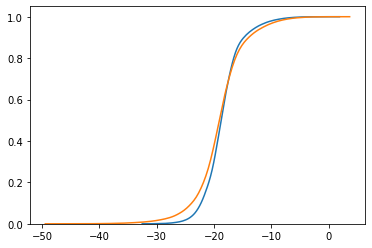

In [41]:
sns.kdeplot(aprendido_red, cumulative=True)
sns.kdeplot(rial, cumulative=True)

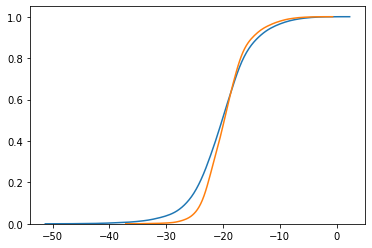

In [42]:
sns.kdeplot(testing, cumulative=True)
sns.kdeplot(prediccion, cumulative=True)

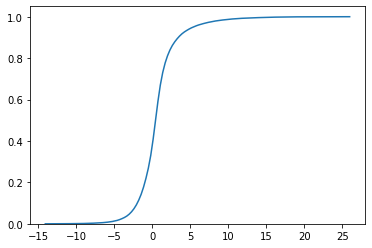

In [43]:
err=prediccion_test-valor_real_test
err_1=err[:,0]
sns.kdeplot(err_1, cumulative=True)

In [0]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(POT2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(POT2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(POT2)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=[12,12])
plt.plot((POT))
plt.plot(trainPredictPlot, color="red", )
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.plot(testPredictPlot, color="green")
plt.title("Predicciones de lo aprendido en rojo y verde en prueba", fontsize = 20)
plt.grid()
plt.show()